## Selecting a Review Dataset

To begin our sentiment analysis, we need a dataset that contains a large number of text reviews spanning multiple categories or topics.


In [1]:
from datasets import load_dataset
import pandas as pd

# Load the dataset from Hugging Face
dataset = load_dataset("yuncongli/chat-sentiment-analysis")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset['train']) 

# Preview
print(df.head(5))

                                         instruction  \
0  extract Aspect-Category-Opinion-Sentiment Quad...   
1  extract Aspect-Category-Opinion-Sentiment Quad...   
2  extract Aspect-Category-Opinion-Sentiment Quad...   
3  extract Aspect-Category-Opinion-Sentiment Quad...   
4  extract Aspect-Category-Opinion-Sentiment Quad...   

                                               input  \
0  judging from previous posts this used to be a ...   
1  we , there were four of us , arrived at noon -...   
2  they never brought us complimentary noodles , ...   
3  the food was lousy - too sweet or too salty an...   
4  after all that , they complained to me about t...   

                                              output  
0  (['place'], RESTAURANT#GENERAL, negative, ['no...  
1   (['staff'], SERVICE#GENERAL, negative, ['rude'])  
2            (None, SERVICE#GENERAL, negative, None)  
3  (['food'], FOOD#QUALITY, negative, ['lousy']);...  
4  (None, SERVICE#GENERAL, negative, ['complained']

## Dataset Overview

This dataset, sourced from Hugging Face, contains a variety of reviews across multiple domains including restaurants, technology, holidays/hotels, etc. Its diverse content makes it well-suited for robust sentiment analysis across different topics.


In [2]:
# Row count
df.shape[0] 

28772

In [3]:
# Drop rows with duplicate inputs
df.drop_duplicates(subset=['input'], inplace=True)

In [4]:
df.shape[0]

11082

In [5]:
df['instruction'].unique()

array(['extract Aspect-Category-Opinion-Sentiment Quadruple from the sentence',
       'detect aspect categories from the sentence',
       'extract holder-target-Opinion-Sentiment Quadruple from the sentence',
       'extract aspect terms from the sentence'], dtype=object)

In [6]:
df['instruction'].value_counts()

instruction
extract aspect terms from the sentence                                   4823
detect aspect categories from the sentence                               3034
extract holder-target-Opinion-Sentiment Quadruple from the sentence      1699
extract Aspect-Category-Opinion-Sentiment Quadruple from the sentence    1526
Name: count, dtype: int64

## Sentiment Labelling Strategy

Many rows in the dataset currently lack an explicit sentiment label in the `output` column. To address this, we will split the dataset into two parts:

1. **Rule-Based Sentiment Extraction**  
   This subset includes rows where we can extract a sentiment label (`positive`, `negative`, or `neutral`) directly from the `output` using keyword matching.

2. **Model-Based Sentiment Prediction**  
   This subset includes rows without a clearly identifiable sentiment. For these, we will use a sentiment analysis API to assign sentiment labels.

After labeling both subsets, we will merge them back into a single DataFrame and proceed with exploratory analysis and comparison.


In [7]:
# Create new DataFrame from rows not containing a sentiment in the output
df_hf = df[df['instruction'].isin([
    'detect aspect categories from the sentence',
    'extract aspect terms from the sentence',
])]

# Select additional rows to add
df_no_tuples = df[
    (df['instruction'] == 'extract holder-target-Opinion-Sentiment Quadruple from the sentence') &
    (df['output'].str.strip().str.lower() == 'there are no tuples')
]

# Append to df_hf
df_hf = pd.concat([df_hf, df_no_tuples], ignore_index=True)

In [8]:
df_hf.shape[0]

8190

In [9]:
# Create new DataFrame from rows containing a sentiment in the output
df_fine = df[
    (df['instruction'].isin([
        'extract holder-target-Opinion-Sentiment Quadruple from the sentence',
        'extract Aspect-Category-Opinion-Sentiment Quadruple from the sentence',
    ])) &
    ~(
        (df['instruction'] == 'extract holder-target-Opinion-Sentiment Quadruple from the sentence') &
        (df['output'].str.strip().str.lower() == 'there are no tuples')
    )
]

In [10]:
df_fine.shape[0]

2892

In [11]:
# Sentiment counts in the output of df_fine 
positive_count = df_fine['output'].str.count(r'(?i)\bpositive\b').sum()
negative_count = df_fine['output'].str.count(r'(?i)\bnegative\b').sum()
neutral_count  = df_fine['output'].str.count(r'(?i)\bneutral\b').sum()

print(positive_count)
print(negative_count)
print(neutral_count)

3692
1508
95


In [12]:
import re

# Simple rule-based sentiment scorer based on keyword frequency
def sentiment_score(text):
    text = text.lower()  # Convert text to lowercase for consistent matching
    
    # Count occurrences of each keyword
    pos = len(re.findall(r'\bpositive\b', text))
    neg = len(re.findall(r'\bnegative\b', text))
    score = pos - neg

    # Return sentiment category based on score
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment scoring to the 'output' column
df_fine = df_fine.copy()
df_fine['predicted_sentiment'] = df_fine['output'].apply(sentiment_score)


In [13]:
positive_count = (df_fine['predicted_sentiment'].str.lower() == 'positive').sum()
negative_count = (df_fine['predicted_sentiment'].str.lower() == 'negative').sum()
neutral_count  = (df_fine['predicted_sentiment'].str.lower() == 'neutral').sum()

print(f"Positive: {positive_count}")
print(f"Negative: {negative_count}")
print(f"Neutral: {neutral_count}")

Positive: 1911
Negative: 805
Neutral: 176


In [14]:
df_hf.head(5)

,instruction,input,output
0,detect aspect categories from the sentence,But the staff was so horrible to us.,service
1,detect aspect categories from the sentence,"To be completely fair, the only redeeming fact...","food,anecdotes/miscellaneous"
2,detect aspect categories from the sentence,"The food is uniformly exceptional, with a very...",food
3,detect aspect categories from the sentence,Where Gabriela personaly greets you and recomm...,service
4,detect aspect categories from the sentence,"For those that go once and don't enjoy it, all...",anecdotes/miscellaneous


In [15]:
from transformers import pipeline

# Load 3-class sentiment model, force PyTorch only
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    framework="pt",  # Forces PyTorch (avoids TensorFlow/Keras issues)
    device=0 # Use GPU instead of CPU
)

# Map model output labels to human-readable ones
label_map = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive'
}

# Apply to dataframe
df_hf['predicted_sentiment'] = df_hf['input'].apply(
    lambda x: label_map[sentiment_analyzer(x)[0]['label']]
)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [16]:
df_hf.head(5)

,instruction,input,output,predicted_sentiment
0,detect aspect categories from the sentence,But the staff was so horrible to us.,service,negative
1,detect aspect categories from the sentence,"To be completely fair, the only redeeming fact...","food,anecdotes/miscellaneous",neutral
2,detect aspect categories from the sentence,"The food is uniformly exceptional, with a very...",food,positive
3,detect aspect categories from the sentence,Where Gabriela personaly greets you and recomm...,service,neutral
4,detect aspect categories from the sentence,"For those that go once and don't enjoy it, all...",anecdotes/miscellaneous,negative


In [17]:
df_hf['predicted_sentiment'].value_counts()

predicted_sentiment
positive    3976
neutral     2349
negative    1865
Name: count, dtype: int64

In [18]:
# Concatenate vertically
df_combined = pd.concat([df_hf, df_fine], ignore_index=True)

In [19]:
df_combined.shape[0]

11082

In [20]:
df_combined['predicted_sentiment'].value_counts()

predicted_sentiment
positive    5887
negative    2670
neutral     2525
Name: count, dtype: int64

In [21]:
# Sentiment percentages
df_combined['predicted_sentiment'].value_counts(normalize=True) * 100

predicted_sentiment
positive    53.122180
negative    24.093124
neutral     22.784696
Name: proportion, dtype: float64

## Sentiment Distribution and Review Length Analysis

Out of over 11,000 reviews, the sentiment distribution is as follows:

- **Positive:** 53.1%  
- **Negative:** 24.1%  
- **Neutral:** 22.8%

As you can see, the majority of the reviews are positive, while the number of neutral and negative reviews is noticeably lower and relatively similar. This suggests a generally favourable sentiment across the dataset.

Now, we will use a variety of plots to explore the relationship between input length (word count of the review) and sentiment category. This will help us understand how the length of the reviews varies across positive, neutral, and negative sentiments.


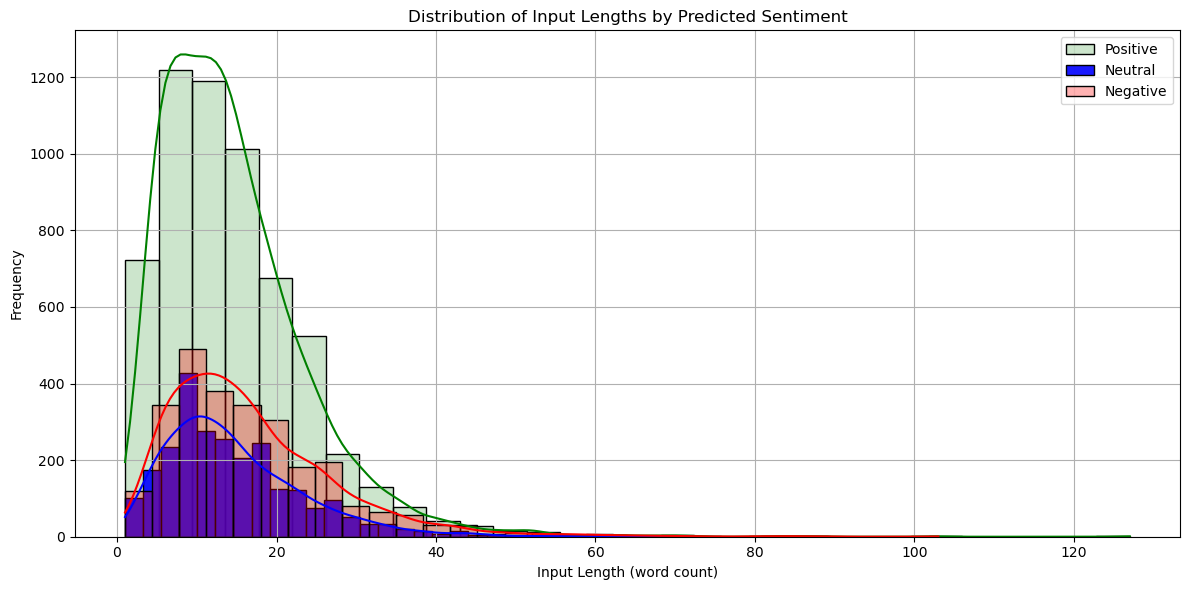

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute input length (word count)
df_combined['input_length'] = df_combined['input'].str.split().apply(len)


plt.figure(figsize=(12, 6))

# Plot each sentiment group 
sns.histplot(
    data=df_combined[df_combined['predicted_sentiment'] == 'positive'],
    x='input_length',
    color='green',
    label='Positive',
    bins=30,
    kde=True,
    alpha=0.2 # Transparency
)

sns.histplot(
    data=df_combined[df_combined['predicted_sentiment'] == 'neutral'],
    x='input_length',
    color='blue',
    label='Neutral',
    bins=30,
    kde=True,
    alpha=0.9
)

sns.histplot(
    data=df_combined[df_combined['predicted_sentiment'] == 'negative'],
    x='input_length',
    color='red',
    label='Negative',
    bins=30,
    kde=True,
    alpha=0.3
)

# Formatting
plt.title('Distribution of Input Lengths by Predicted Sentiment')
plt.xlabel('Input Length (word count)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


From the plot above, we observe that the word count distribution of reviews is quite similar across the different sentiment categories and appears to resemble a gamma distribution, characterised by its right skew.

Next, let's visualise the data using a boxplot to better understand the distribution of review lengths within each sentiment category.


C:\Users\the3s\AppData\Local\Temp\ipykernel_19796\2061267234.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


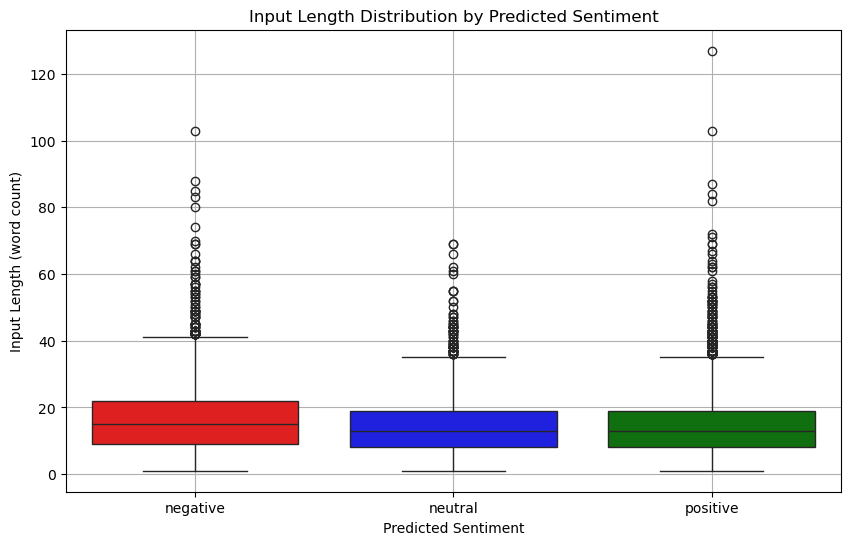

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_combined, 
    x='predicted_sentiment', 
    y='input_length', 
    palette={'positive': 'green', 'neutral': 'blue', 'negative': 'red'}
)
plt.title('Input Length Distribution by Predicted Sentiment')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Input Length (word count)')
plt.grid(True)
plt.show()

Let's remove outliers from the boxplot to improve readability and focus on the main distribution of review lengths within each sentiment category.

In [24]:
# Initialise a dictionary to store the number of outliers for each sentiment group
outlier_counts = {}

# Group the DataFrame by 'predicted_sentiment' and iterate over each group
for sentiment, group in df_combined.groupby('predicted_sentiment'):
    q1 = group['input_length'].quantile(0.25)
    q3 = group['input_length'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr # Define outlier bounds
    upper_bound = q3 + 1.5 * iqr

    outliers = group[(group['input_length'] < lower_bound) | (group['input_length'] > upper_bound)] # Identify outliers
    outlier_counts[sentiment] = len(outliers) # Store the count of outliers for the current sentiment group

print("Outlier counts by sentiment:")
for sentiment, count in outlier_counts.items():
    print(f"{sentiment}: {count} outliers")

Outlier counts by sentiment:
negative: 79 outliers
neutral: 70 outliers
positive: 170 outliers


This outlier count is unsurprising, as all categories have similar variance and distribution shapes, so the number of outliers roughly scales with the difference in category size.

C:\Users\the3s\AppData\Local\Temp\ipykernel_19796\1793601415.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df_combined.groupby('predicted_sentiment', group_keys=False).apply(is_outlier)
C:\Users\the3s\AppData\Local\Temp\ipykernel_19796\1793601415.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_no_outliers, x='predicted_sentiment', y='input_length', palette={'positive': 'green', 'neutral': 'blue', 'negative': 'red'})


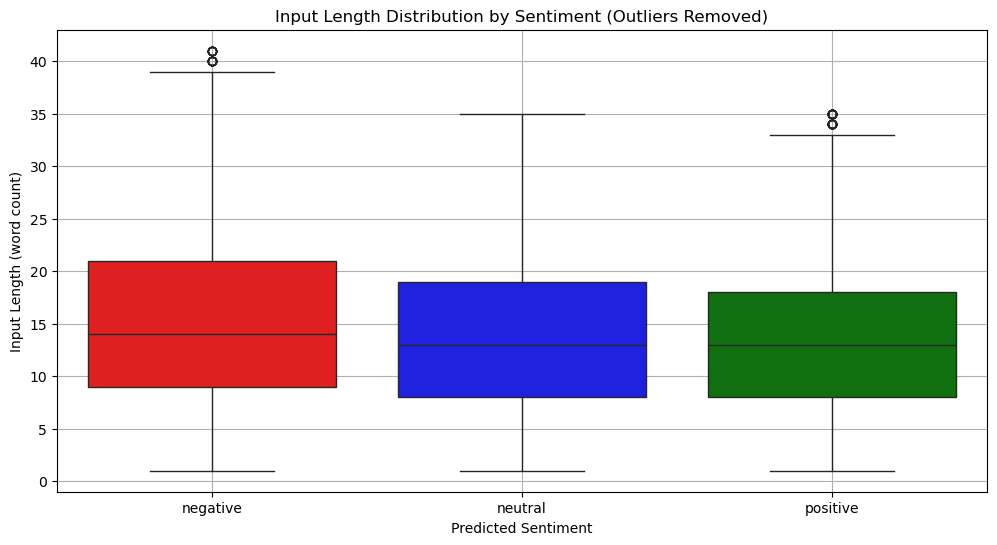

In [25]:
# Define a function to remove outliers from each group based on the IQR method
def is_outlier(group):
    q1 = group['input_length'].quantile(0.25)
    q3 = group['input_length'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    # Return only rows where 'input_length' is within the non-outlier range
    return group[(group['input_length'] >= lower) & (group['input_length'] <= upper)]

df_no_outliers = df_combined.groupby('predicted_sentiment', group_keys=False).apply(is_outlier)

# Replot boxplot without outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_no_outliers, x='predicted_sentiment', y='input_length', palette={'positive': 'green', 'neutral': 'blue', 'negative': 'red'})
plt.title('Input Length Distribution by Sentiment (Outliers Removed)')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Input Length (word count)')
plt.grid(True)
plt.show()


Once again, we observe that the distributions are relatively similar across the sentiment groups. Negative reviews tend to be slightly longer than the others by a few words on average. The empirical cumulative distribution function (ECDF) plot below also shows this.

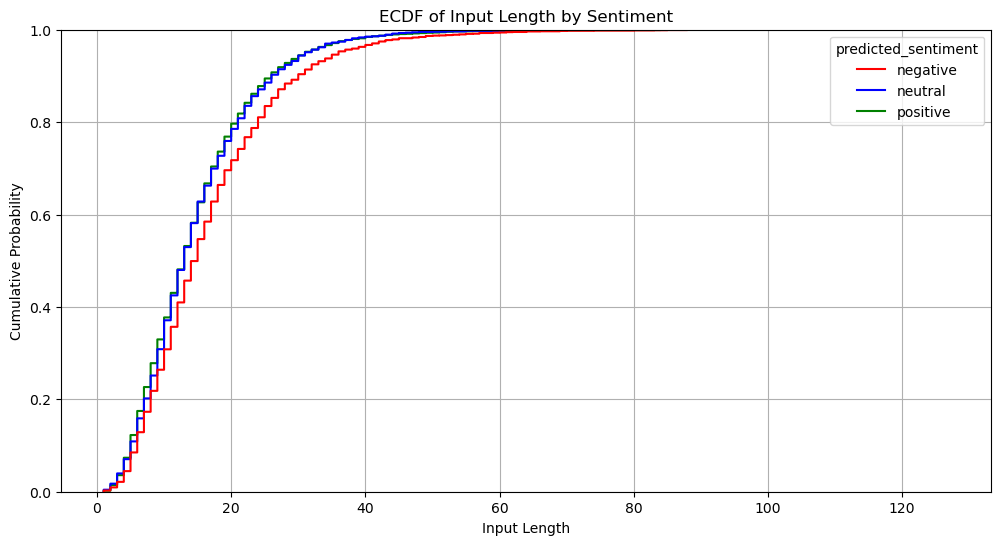

In [26]:
plt.figure(figsize=(12, 6))
sns.ecdfplot(data=df_combined, x='input_length', hue='predicted_sentiment', palette={'positive': 'green', 'neutral': 'blue', 'negative': 'red'})
plt.title('ECDF of Input Length by Sentiment')
plt.xlabel('Input Length')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()


Next, we'll conduct some statistical analyses to formally examine the differences between the sentiment groups.

In [34]:
from scipy import stats

def descriptive_stats(group):
    lengths = group['input_length']
    mean = lengths.mean()
    median = lengths.median()
    iqr = stats.iqr(lengths)
    variance = lengths.var()
    
    # 95% CI for the mean
    sem = stats.sem(lengths)
    ci_mean = stats.t.interval(0.95, len(lengths)-1, loc=mean, scale=sem)
    
    # 95% CI for the median (using bootstrapping)
    boot_medians = [np.median(np.random.choice(lengths, size=len(lengths), replace=True)) for _ in range(1000)]
    ci_median = np.percentile(boot_medians, [2.5, 97.5])
    
    return pd.Series({
        'mean': mean,
        '95% CI (mean)': f"[{ci_mean[0]:.2f}, {ci_mean[1]:.2f}]",
        'median': median,
        '95% CI (median)': f"[{ci_median[0]:.2f}, {ci_median[1]:.2f}]",
        'IQR': iqr,
        'variance': variance
    })

# Group by sentiment and apply
summary_table = df_combined.groupby('predicted_sentiment').apply(descriptive_stats)

print(summary_table)

                          mean   95% CI (mean)  median 95% CI (median)   IQR  \
predicted_sentiment                                                            
negative             16.739326  [16.33, 17.14]    15.0  [14.00, 15.00]  13.0   
neutral              14.718812  [14.37, 15.07]    13.0  [13.00, 13.00]  11.0   
positive             14.569220  [14.33, 14.80]    13.0  [13.00, 13.00]  11.0   

                       variance  
predicted_sentiment              
negative             114.245999  
neutral               79.276686  
positive              85.038319  


C:\Users\the3s\AppData\Local\Temp\ipykernel_19796\167734722.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_table = df_combined.groupby('predicted_sentiment').apply(descriptive_stats)


## Overview of Review Lengths by Predicted Sentiment

- **Negative reviews** tend to be slightly longer on average, with a mean input length of about 16.7 words and a median of 15 words. They also show the greatest variability in length, indicated by the highest variance (114.2) and widest interquartile range (IQR) of 13.

- **Neutral and positive reviews** have similar average lengths, with means around 14.7 and 14.6 words respectively, and medians both at 13 words. Their variances and IQRs are also similar and lower than those of negative reviews, indicating less spread in length.

- The 95% confidence intervals for both the mean and median overlap between the sentiment groups, suggesting that differences in review length are relatively modest.

Overall, negative reviews are on average a bit longer and more variable in length compared to neutral and positive reviews. Now let us look at formal statistical tests for further insight.

## Kruskal–Wallis H-Test

The Kruskal–Wallis test is a non-parametric method used to compare the medians of three or more independent groups without assuming normality.

We apply it here to test whether review lengths differ between positive, neutral, and negative sentiment groups. Since the data are skewed and do not meet the normality assumption, the Kruskal–Wallis test is appropriate, as opposed to ANOVA which requires normally distributed groups.
The result shows a significant difference (p < 0.05) in review lengths among the sentiment categories, suggesting sentiment relates to review length.


In [36]:
from scipy.stats import kruskal

# Extract input lengths by sentiment category
pos_lengths = df_combined[df_combined['predicted_sentiment'] == 'positive']['input_length']
neg_lengths = df_combined[df_combined['predicted_sentiment'] == 'negative']['input_length']
neu_lengths = df_combined[df_combined['predicted_sentiment'] == 'neutral']['input_length']

# Perform Kruskal–Wallis H test
statistic, p_value = kruskal(pos_lengths, neg_lengths, neu_lengths)

print("Kruskal–Wallis H-test result:")
print(f"Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4e}")

# Optional interpretation
if p_value < 0.05:
    print("→ There is a statistically significant difference in input length between at least two sentiment categories.")
else:
    print("→ No statistically significant difference in input length between sentiment categories.")


Kruskal–Wallis H-test result:
Statistic: 81.3600
P-value: 2.1523e-18
→ There is a statistically significant difference in input length between at least two sentiment categories.


## Mann-Whitney U Test

We will now use the Mann–Whitney U test to perform pairwise comparisons between sentiment groups. Again, this is a non-parametric test (does not assume normality) that helps us identify which specific groups differ significantly in review length. Additionally, we calculate effect sizes to understand the practical significance of these differences, beyond just statistical significance.


In [37]:
from scipy.stats import mannwhitneyu
import itertools

# Function to calculate rank-biserial correlation (effect size)
def rank_biserial_effect_size(group1, group2):
    u_stat, _ = mannwhitneyu(group1, group2, alternative='two-sided')
    n1, n2 = len(group1), len(group2)
    return 1 - (2 * u_stat) / (n1 * n2)

# Prepare data
groups = {
    'positive': df_combined[df_combined['predicted_sentiment'] == 'positive']['input_length'],
    'negative': df_combined[df_combined['predicted_sentiment'] == 'negative']['input_length'],
    'neutral':  df_combined[df_combined['predicted_sentiment'] == 'neutral']['input_length']
}

# Run tests
print("Pairwise Mann–Whitney U Tests and Effect Sizes:\n")
for (label1, data1), (label2, data2) in itertools.combinations(groups.items(), 2):
    u_stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
    effect_size = rank_biserial_effect_size(data1, data2)

    print(f"{label1.capitalize()} vs {label2.capitalize()}:")
    print(f"  U-statistic = {u_stat:.2f}")
    print(f"  p-value     = {p_val:.4e}")
    print(f"  Effect size = {effect_size:.4f}\n")


Pairwise Mann–Whitney U Tests and Effect Sizes:

Positive vs Negative:
  U-statistic = 6922643.00
  p-value     = 8.5714e-19
  Effect size = 0.1192

Positive vs Neutral:
  U-statistic = 7313291.00
  p-value     = 2.4315e-01
  Effect size = 0.0160

Negative vs Neutral:
  U-statistic = 3721845.00
  p-value     = 7.9847e-11
  Effect size = -0.1041



## Results 

- **Positive vs Negative:**  
  The test shows a highly significant difference in review lengths (p < 0.05) with a small effect size (0.12). This indicates that negative reviews tend to be slightly longer than positive ones, but the practical difference is modest.

- **Positive vs Neutral:**  
  There is no significant difference in review lengths (p = 0.24) and a very small effect size (0.02), suggesting these two groups have similar review lengths.

- **Negative vs Neutral:**  
  A significant difference is observed (p < 0.05) with a small effect size (-0.10), indicating negative reviews are somewhat longer than neutral reviews, though the difference is again small in practical terms.

Overall, while some statistically significant differences exist, the effect sizes suggest that the differences in review length across sentiment categories are generally small.

## Conclusion

In this analysis, we began by cleaning the dataset and handling missing sentiment labels by using an API to predict the sentiment for reviews without assigned categories. This allowed us to create a comprehensive dataset with three sentiment groups: positive, neutral, and negative.

We then explored the data visually, examining the distribution of review lengths across sentiment categories using histograms, boxplots, and ECDF plots. These visualisations revealed that review lengths are generally similar across sentiments, with negative reviews tending to be slightly longer.

To formally test these observations, we conducted statistical analyses suitable for the skewed distribution of review lengths. The Kruskal–Wallis H test showed significant differences in review lengths among the three sentiment groups. Pairwise Mann–Whitney U tests further identified that negative reviews differ significantly in length compared to positive and neutral reviews, although the effect sizes were small, indicating these differences are minor in practical terms.

Overall, the combined approach of data cleaning, visualisation, and appropriate non-parametric statistical testing provided a clear understanding of how review length varies with sentiment, confirming subtle but significant variations across categories.


## Extra Analysis (Generalised Linear Model)

As noted earlier, the distribution of review lengths closely resembles a gamma distribution, which motivated fitting a Generalised Linear Model (GLM) with a Gamma family and a log link function. This approach is appropriate for modelling positively skewed data. However, the resulting model showed an extremely low pseudo R-squared value, indicating that sentiment category explains very little of the variation in review length. For this reason, we have not included the GLM results as a primary part of the analysis, but it serves as a useful confirmation that other factors beyond sentiment are likely driving review length variability.

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit Gamma GLM with log link
model = smf.glm(
    formula='input_length ~ C(predicted_sentiment)', 
    data=df_combined, 
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           input_length   No. Observations:                11082
Model:                            GLM   Df Residuals:                    11079
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                         0.39443
Method:                          IRLS   Log-Likelihood:                -38715.
Date:                Mon, 30 Jun 2025   Deviance:                       4220.3
Time:                        17:25:22   Pearson chi2:                 4.37e+03
No. Iterations:                     7   Pseudo R-squ. (CS):           0.008750
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

C:\Users\the3s\AnacondaInstall\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
